In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.linalg import cholesky, lstsq


In [75]:
from experiments import EffectCorrelation
from experiments import utilities as utils
from bayesinverse import Regression
import robiplotipy.experiments.effect_correlation as plt_exp
from robiplotipy import PlotEnv


In [76]:
config_path = config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/effect_correlation/config.yaml"
)

exp = EffectCorrelation(config_path)


sensors 0.0029757320880889893


/home/rmaiwald/code/Experiments/experiments/shared/emissions.py:301: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  tno_points_gdf = pickle.load(file)


emissions 1.8755475580692291
transport 4.459379464387894


In [77]:
exp.load_data()
rmse_list = exp.data["rmse_list"]
posterior_list = exp.data["posterior_list"]
posterior_covariance_list = exp.data["posterior_covariance_list"]
corr_strength_list = exp.data["corr_strength_list"]


Plotting

Plot effect of correlation length for each sector

In [78]:
point_index = exp.emissions.source_group_df.query("source_type == 'point source'").index
traffic_index = exp.emissions.source_group_df.query(
    "source_type == 'line source'"
).index
tno_area_index = exp.emissions.source_group_df.query("source_type == 'TNO area'").index
heating_index = exp.emissions.source_group_df.query(
    "source_type == 'Stadtwerke area'"
).index
valid_index = exp.emissions.source_group_df.query("source_type != '0.0'").index


In [79]:
plot_env = PlotEnv(
    fig_path="/home/rmaiwald/results/plotting/effect_correlation/",
    logging=True,
    display=True,
)


In [80]:
index_list = [point_index, traffic_index, tno_area_index, heating_index, valid_index]
label_list = ["points", "traffic", "TNO area", "Stadtwerke", "Total"]
data_list = []
for index, label in zip(index_list, label_list):
    rmse_list = []
    for posterior in posterior_list:
        error = posterior - exp.emissions.truth_absolute
        rmse_list.append(
            np.sqrt(np.mean(error.sel(source_group=index).sum("source_group") ** 2))
        )
    data_list.append(rmse_list)


In [81]:
y_label = r"RMSE of the sum of the CO$_2$ emissions [kg/h]"


[Errno 17] File exists: '/home/rmaiwald/results/plotting/effect_correlation/absolute_rmse_over_correlation/config_log.yml'


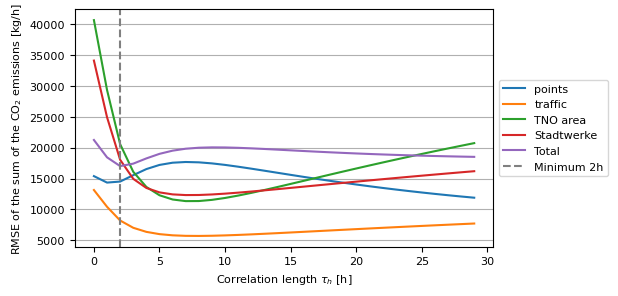

In [82]:
with plot_env(
    name="absolute_rmse_over_correlation",
    notes=exp.config,
):
    plt_exp.plot_list_over_correlation_length(
        env=plot_env,
        correlation_list=corr_strength_list,
        data_list=data_list,
        data_label_list=label_list,
        y_label=y_label,
    )


In [83]:
# index_list = [point_index, traffic_index, heating_index, valid_index]
# label_list = ["points", "traffic", "Stadtwerke", "Total"]
index_list = [point_index, traffic_index, tno_area_index, heating_index, valid_index]
label_list = ["points", "traffic", "TNO area", "Stadtwerke", "Total"]
data_list = []
for index, label in zip(index_list, label_list):
    rmse_list = []
    for posterior in posterior_list:
        error = posterior - exp.emissions.truth_absolute
        scaling = np.sqrt(
            (
                (posterior_list[0] - exp.emissions.truth_absolute)
                .sel(source_group=index)
                .sum("source_group")
                ** 2
            ).mean()
        )
        # scaling = np.sqrt((
        #     exp.emissions.truth_absolute.sel(source_group=index)
        #     .sum("source_group")**2)
        #     .mean()
        # )
        rmse = np.sqrt(np.mean(error.sel(source_group=index).sum("source_group") ** 2))
        rmse_list.append(rmse / scaling * 100)
    data_list.append(rmse_list)


In [84]:
y_label = r"Relative RMSE of the sum" "\n" "of the CO$_2$ emissions [%]"


[Errno 17] File exists: '/home/rmaiwald/results/plotting/effect_correlation/relative_rmse_over_correlation/config_log.yml'


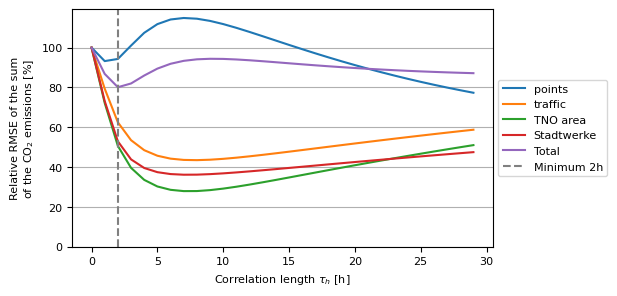

In [85]:
with plot_env(
    name="relative_rmse_over_correlation",
    notes=exp.config,
):
    plt_exp.plot_list_over_correlation_length(
        env=plot_env,
        correlation_list=corr_strength_list,
        data_list=data_list,
        data_label_list=label_list,
        y_label=y_label,
        bottom=0,
    )


In [86]:
total_rmse = np.array(data_list)[np.where(np.array(label_list) == "Total")]
min_id = total_rmse.argmin()
minimum = corr_strength_list[min_id]
minimum


2.00000001

Without point sources

In [87]:
mask = (
    (exp.emissions.source_group_df["source_type"] == "line source")
    | (exp.emissions.source_group_df["source_type"] == "TNO area")
    | (exp.emissions.source_group_df["source_type"] == "Stadtwerke area")
)
source_groups_without_points = exp.emissions.source_group_df.index[mask]


In [88]:
time, mean, std, mean_cor, std_cor, mean_prior, mean_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior_list[0],
    posterior_covariance_0=posterior_covariance_list[0],
    posterior_1=posterior_list[min_id],
    posterior_covariance_1=posterior_covariance_list[min_id],
    index=source_groups_without_points,
)


In [89]:
y_label = r"Total CO$_2$ emissions" "\n" "without point sources [kg/h]"


In [90]:
print("RMSE: {}".format(utils.compute_rmse(mean, mean_truth).values))
print("RMSE: {}".format(utils.compute_rmse(mean_cor, mean_truth).values))


RMSE: 14338.52702411557
RMSE: 9040.361359679222


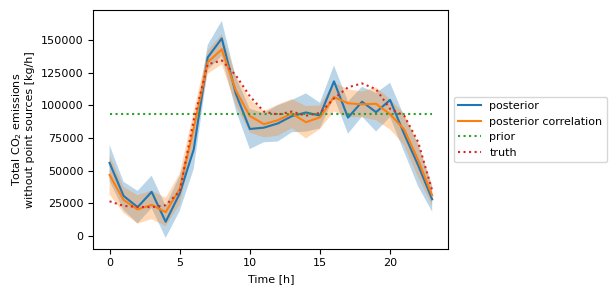

In [91]:
with plot_env(
    name="correlation_without_point_sources",
    notes=exp.config,
):
    plt_exp.plot_correlation_time_series(
        env=plot_env,
        time=time,
        mean=mean,
        std=std,
        mean_cor=mean_cor,
        std_cor=std_cor,
        mean_prior=mean_prior,
        mean_truth=mean_truth,
        y_label=y_label,
    )


With point sources

In [92]:
time, mean, std, mean_cor, std_cor, mean_prior, mean_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior_list[0],
    posterior_covariance_0=posterior_covariance_list[0],
    posterior_1=posterior_list[min_id],
    posterior_covariance_1=posterior_covariance_list[min_id],
    index=valid_index,
)


In [93]:
y_label = r"Total CO$_2$ emissions [kg/h]"


In [94]:
print("RMSE: {}".format(utils.compute_rmse(mean, mean_truth).values))
print("RMSE: {}".format(utils.compute_rmse(mean_cor, mean_truth).values))


RMSE: 21253.70138049709
RMSE: 17023.640024335156


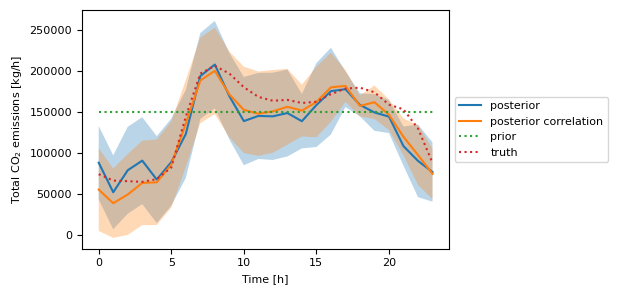

In [96]:
with plot_env(
    name="correlation",
    notes=exp.config,
):
    plt_exp.plot_correlation_time_series(
        env=plot_env,
        time=time,
        mean=mean,
        std=std,
        mean_cor=mean_cor,
        std_cor=std_cor,
        mean_prior=mean_prior,
        mean_truth=mean_truth,
        y_label=y_label,
    )


Just points

In [97]:
time, mean, std, mean_cor, std_cor, mean_prior, mean_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior_list[0],
    posterior_covariance_0=posterior_covariance_list[0],
    posterior_1=posterior_list[min_id],
    posterior_covariance_1=posterior_covariance_list[min_id],
    index=point_index,
)


In [98]:
y_label = r"Total CO$_2$ emissions from point sources [kg/h]"


In [99]:
print("RMSE: {}".format(utils.compute_rmse(mean, mean_truth).values))
print("RMSE: {}".format(utils.compute_rmse(mean_cor, mean_truth).values))


RMSE: 15401.11867254708
RMSE: 14521.987462486586


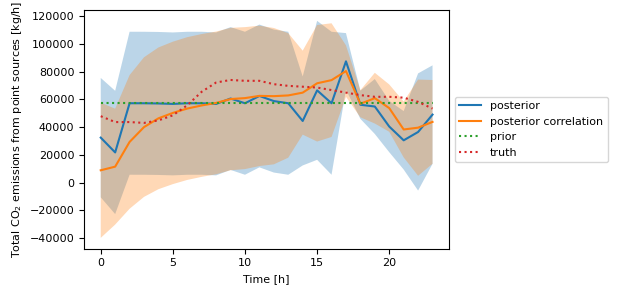

In [100]:
with plot_env(
    name="correlation_points",
    notes=exp.config,
):
    plt_exp.plot_correlation_time_series(
        env=plot_env,
        time=time,
        mean=mean,
        std=std,
        mean_cor=mean_cor,
        std_cor=std_cor,
        mean_prior=mean_prior,
        mean_truth=mean_truth,
        y_label=y_label,
    )


Traffic

In [101]:
time, mean, std, mean_cor, std_cor, mean_prior, mean_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior_list[0],
    posterior_covariance_0=posterior_covariance_list[0],
    posterior_1=posterior_list[min_id],
    posterior_covariance_1=posterior_covariance_list[min_id],
    index=traffic_index,
)


In [102]:
y_label = r"Total CO$_2$ emissions from line sources [kg/h]"


In [103]:
print("RMSE: {}".format(utils.compute_rmse(mean, mean_truth).values))
print("RMSE: {}".format(utils.compute_rmse(mean_cor, mean_truth).values))


RMSE: 13150.746669202223
RMSE: 8215.252865833681


In [104]:
exp.config


{'emissions': {'correlation': {'tau_d': 1e-05, 'tau_h': 0.5, 'tau_l': None},
  'prior': 'mean_TNO_with_points',
  'prior_mode': 'constant_diurnal',
  'prior_variance': 'mean_TNO_variance',
  'truth': 'combined_emissions',
  'truth_mode': 'single_diurnal'},
 'paths': {'data_jar': '/home/rmaiwald/results/experiments/'},
 'reader': {'catalog_path': '/mnt/data/users/rmaiwald/GRAMM-GRAL/gral/gramm_catalog/',
  'config_path': '/mnt/data/users/rmaiwald/GRAMM-GRAL/gral/gral_sim_path_05/config/',
  'simulation_path': '/mnt/data/users/rmaiwald/GRAMM-GRAL/gral/gral_sim_path_05/'},
 'seed': 42,
 'sensors': {'height': 0, 'n_sensors': 10, 'noise': 1.0},
 'time': 120,
 'transport': {'mode': 'realistic'}}

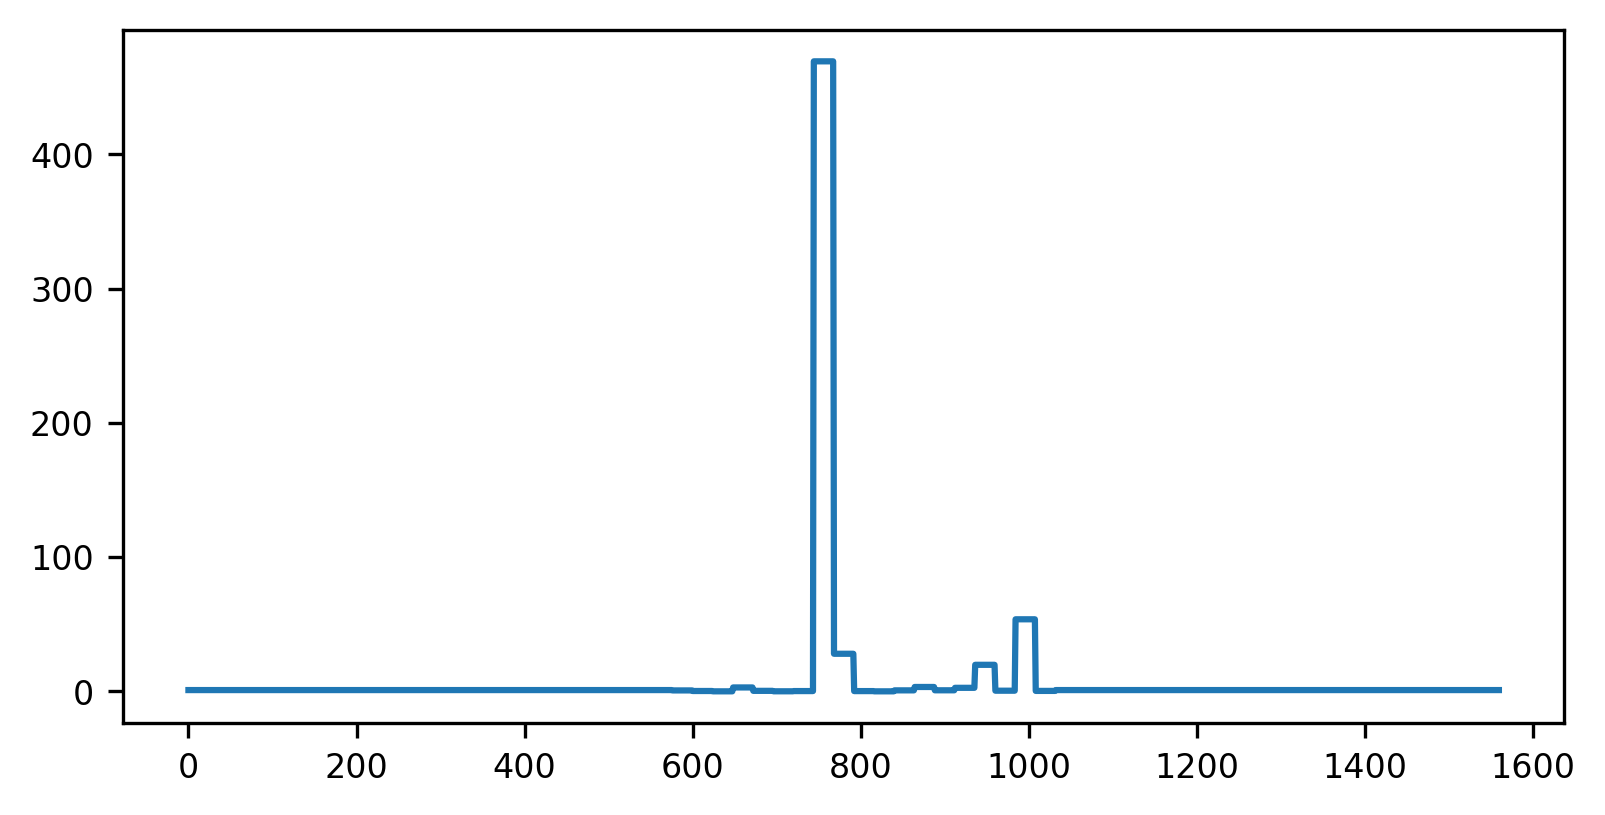

In [105]:
plt.plot(np.diag(utils.stack_xr(exp.emissions.prior_covariance).values))


In [106]:
covariance = utils.unstack_xr(exp.emissions.prior_covariance)
covariance = (
    covariance
    * exp.emissions.absolute_emissions
    * exp.emissions.absolute_emissions.rename({"source_group": "source_group_2"})
)


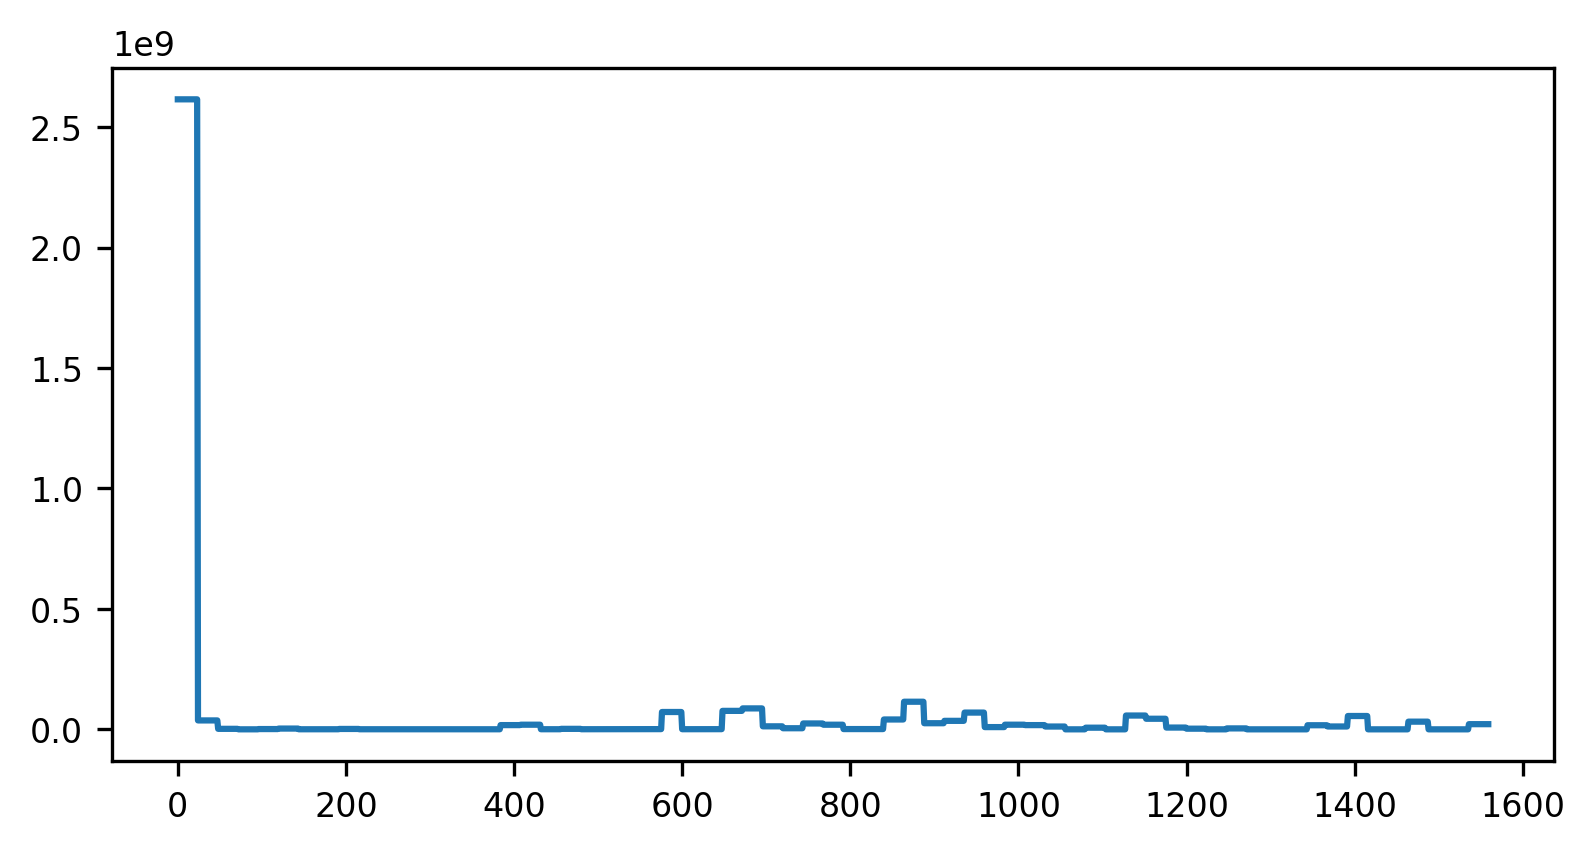

In [107]:
plt.plot(np.diag(utils.stack_xr(covariance).values))


In [108]:
covariance = utils.unstack_xr(exp.emissions.to_xr(posterior_covariance_list[0]))
covariance = (
    covariance
    * exp.emissions.absolute_emissions
    * exp.emissions.absolute_emissions.rename({"source_group": "source_group_2"})
)


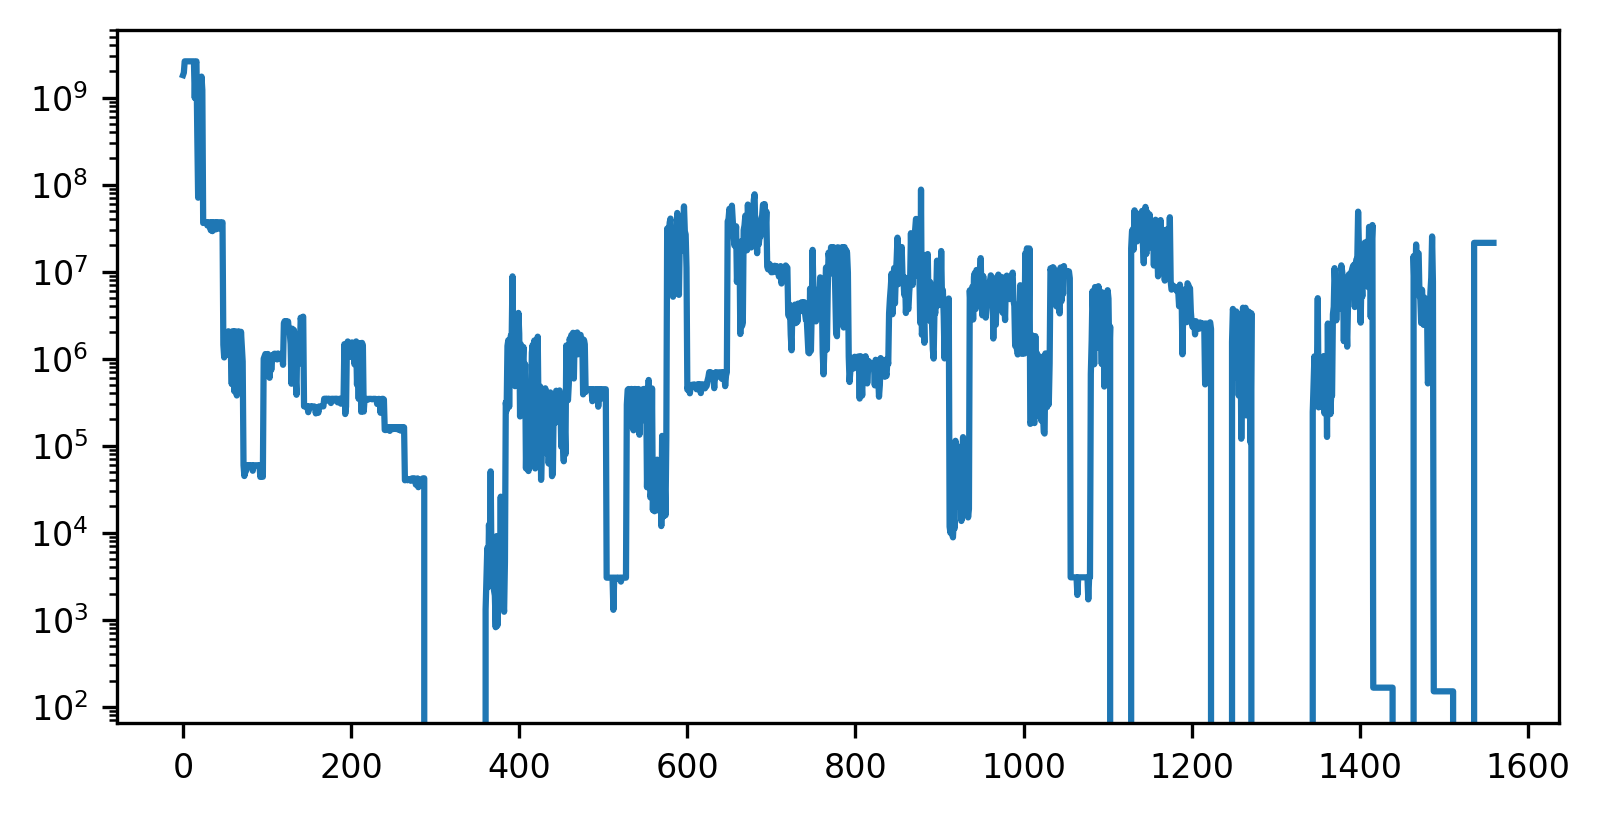

In [109]:
plt.plot(np.diag(utils.stack_xr(covariance).values))
plt.yscale("log")


In [110]:
isinstance(posterior_covariance_list[0], np.ndarray)


True

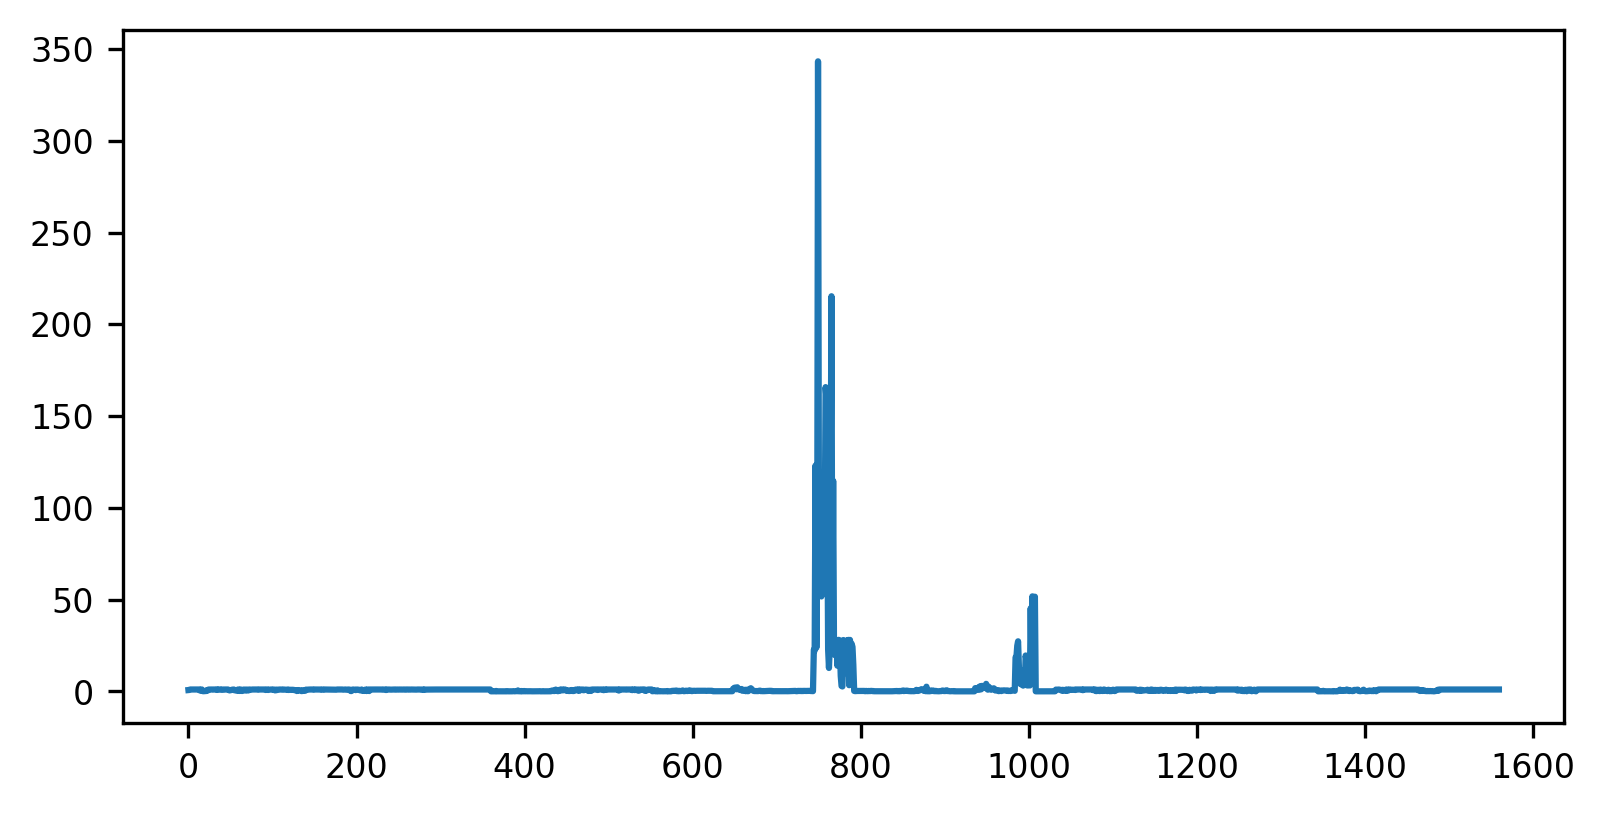

In [111]:
plt.plot(np.diag(posterior_covariance_list[0]))


In [112]:
std


array([3363, 2913, 2956, 3310, 3377, 3521, 3441, 2860, 4278, 2960, 3610,
       3206, 3611, 3249, 3381, 3244, 3256, 2923, 3336, 3097, 2814, 3649,
       3407, 2972])

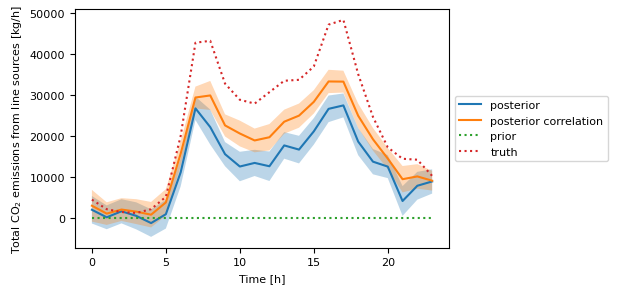

In [113]:
with plot_env(
    name="correlation_traffic",
    notes=exp.config,
):
    plt_exp.plot_correlation_time_series(
        env=plot_env,
        time=time,
        mean=mean,
        std=std,
        mean_cor=mean_cor,
        std_cor=std_cor,
        mean_prior=mean_prior,
        mean_truth=mean_truth,
        y_label=y_label,
    )


TNO area

In [115]:
time, mean, std, mean_cor, std_cor, mean_prior, mean_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior_list[0],
    posterior_covariance_0=posterior_covariance_list[0],
    posterior_1=posterior_list[min_id],
    posterior_covariance_1=posterior_covariance_list[min_id],
    index=tno_area_index,
)


In [116]:
y_label = r"Total CO$_2$ emissions " "\n" "from TNO area sources [kg/h]"


In [117]:
print("RMSE: {}".format(utils.compute_rmse(mean, mean_truth).values))
print("RMSE: {}".format(utils.compute_rmse(mean_cor, mean_truth).values))


RMSE: 40661.49863269638
RMSE: 20571.24384366151


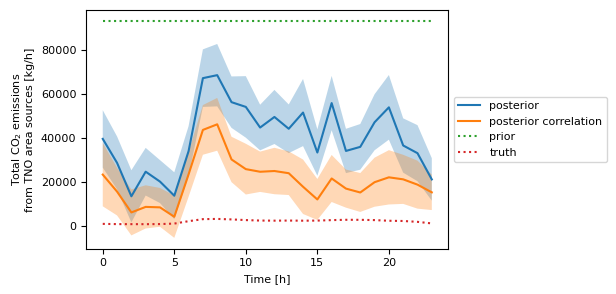

In [119]:
with plot_env(
    name="correlation_TNO_area",
    notes=exp.config,
):
    plt_exp.plot_correlation_time_series(
        env=plot_env,
        time=time,
        mean=mean,
        std=std,
        mean_cor=mean_cor,
        std_cor=std_cor,
        mean_prior=mean_prior,
        mean_truth=mean_truth,
        y_label=y_label,
    )


Stationary combustion

In [120]:
time, mean, std, mean_cor, std_cor, mean_prior, mean_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior_list[0],
    posterior_covariance_0=posterior_covariance_list[0],
    posterior_1=posterior_list[min_id],
    posterior_covariance_1=posterior_covariance_list[min_id],
    index=heating_index,
)


In [121]:
y_label = r"Total CO$_2$ emissions" "\n" "from SWHD area sources [kg/h]"


In [122]:
print("RMSE: {}".format(utils.compute_rmse(mean, mean_truth).values))
print("RMSE: {}".format(utils.compute_rmse(mean_cor, mean_truth).values))


RMSE: 34109.693885327215
RMSE: 18046.683316338513


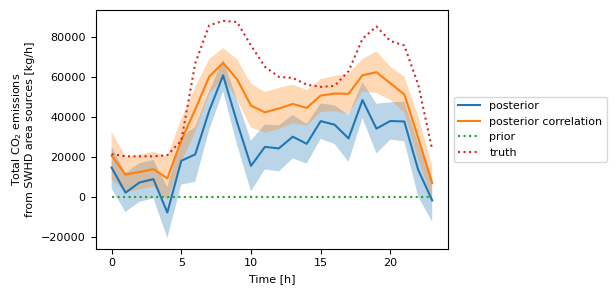

In [125]:
with plot_env(
    name="correlation_heating",
    notes=exp.config,
):
    plt_exp.plot_correlation_time_series(
        env=plot_env,
        time=time,
        mean=mean,
        std=std,
        mean_cor=mean_cor,
        std_cor=std_cor,
        mean_prior=mean_prior,
        mean_truth=mean_truth,
        y_label=y_label,
    )


Overview

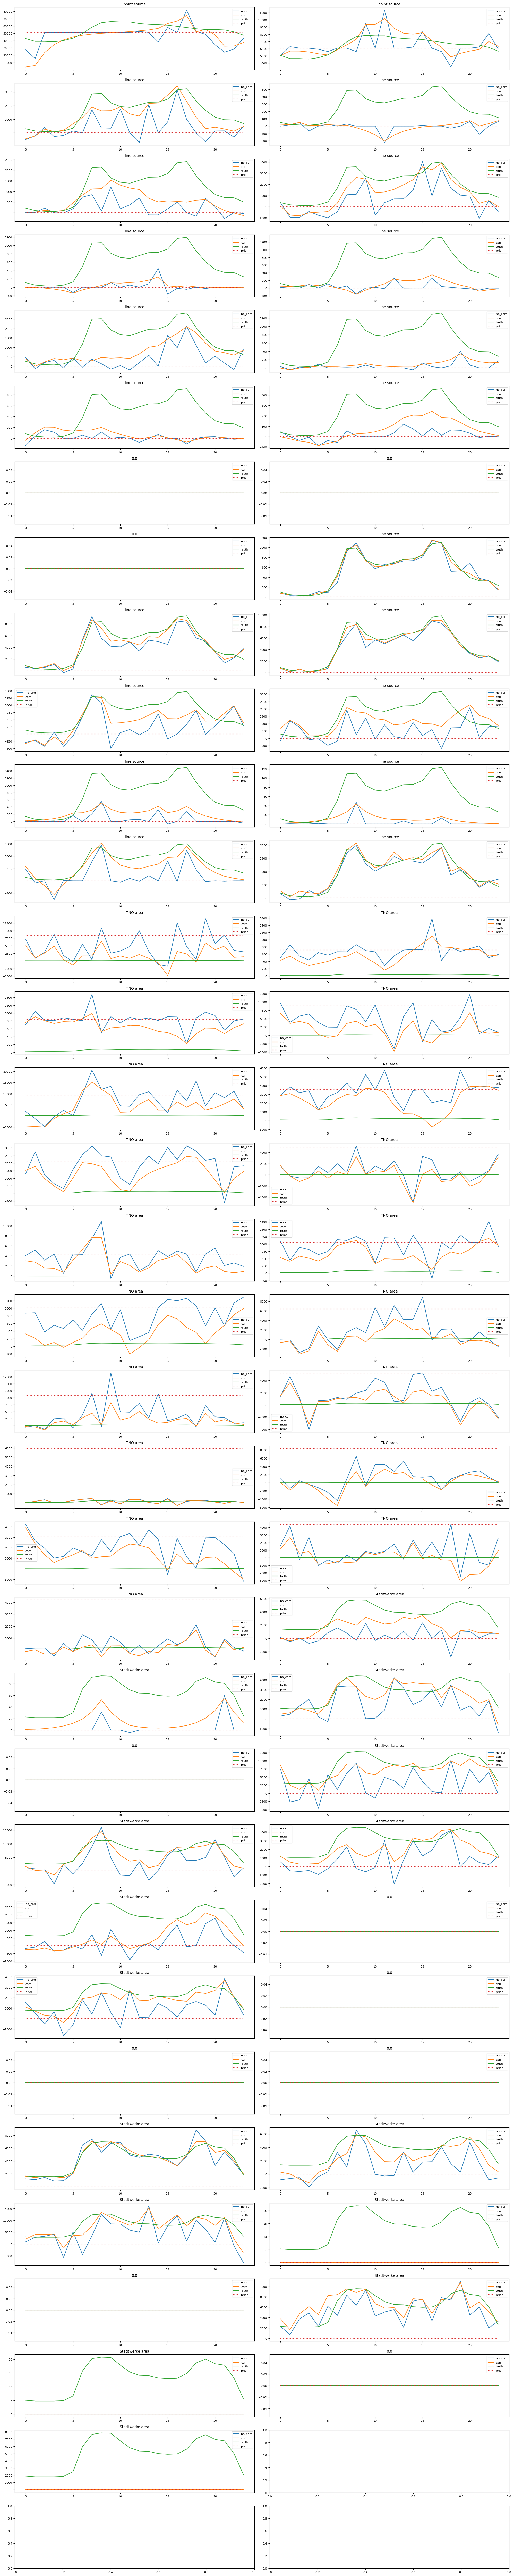

In [126]:
fig, axs = plt.subplots(figsize=(20, 100), nrows=34, ncols=2)
fig.set_dpi(100)

axs = axs.flatten()

for i, source_group in enumerate(exp.emissions.prior["source_group"].values):
    prior_sum = exp.emissions.prior["source_group"].sel(source_group=source_group).sum()
    truth_sum = exp.emissions.truth["source_group"].sel(source_group=source_group).sum()
    if prior_sum > 0 or truth_sum > 0:
        ax = axs[i]
        ax.plot(
            (utils.unstack_xr(posterior_list[0])).sel(source_group=source_group),
            "-",
            label="no_corr",
        )
        ax.plot(
            (utils.unstack_xr(posterior_list[min_id])).sel(source_group=source_group),
            "-",
            label="corr",
        )
        ax.plot(
            exp.emissions.truth_absolute.sel(source_group=source_group), label="truth"
        )
        ax.plot(
            exp.emissions.prior_absolute.sel(source_group=source_group),
            ":",
            label="prior",
        )
        ax.set_title(exp.emissions.source_group_df["source_type"].loc[source_group])
        ax.legend()
    else:
        i -= 1
plt.tight_layout()
